230208

Lorenz

y1' = alpha*(y2 - y1)

y2' = y1*(p - y3) - y2

y3' = y1*y2 - beta*y3

t 범위는 [0, 1]

bias = [-10, -10, 25]

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from openpyxl import Workbook

In [3]:
def Lorenz_x(n = 20):
    x = np.linspace(0, 1, n).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    return x

def Lorenz_y(x, w, idx, bias): 
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    w = w.v[idx]
    n = w.shape[0]

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y

def Lorenz_loss(x, w, bias, p, alpha, beta):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y1, y2, y3 = [Lorenz_y(x, w, idx = idx, bias = b) for idx, b in enumerate(bias)]
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)
        d_y3 = tape.gradient(y3, x)

        # y1' - (alpha*(y2 - y1))
        # y2' - (y1*(p - y3) - y2)
        # y3' - (y1*y2 - beta*y3)
        loss_1 = d_y1 - (alpha*(y2 - y1))
        loss_2 = d_y2 - (y1*(p - y3) - y2)
        loss_3 = d_y3 - (y1*y2 - beta*y3)
        square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_3)
        total_loss = tf.reduce_mean(square_loss)

        grad_w = tape.gradient(total_loss, w.trainable_variables)
    return grad_w, total_loss

def Lorenz_w(w_n, bias, p, alpha, beta, n = 20):
    # custom train_x
    train_x = Lorenz_x(n = n)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(len(bias), w_n), dtype=tf.float32))

    print('Start Lorenz : {}차'.format(w_n))
    save_loss = 0
    for itr in range(10001):
        # custom loss
        grad_w, total_loss = Lorenz_loss(train_x, w, bias, p, alpha, beta)
        optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return w

In [40]:
w_1 = Lorenz_w(w_n = 1, n = 20, bias = [-10, -10, 25], p = 28, alpha = 10, beta = 8/3)
w_2 = Lorenz_w(w_n = 2, n = 20, bias = [-10, -10, 25], p = 28, alpha = 10, beta = 8/3)
w_3 = Lorenz_w(w_n = 3, n = 20, bias = [-10, -10, 25], p = 28, alpha = 10, beta = 8/3)

Start Lorenz : 1차
iter : 0, y_loss : 901.4763793945312
iter : 5000, y_loss : 350.9187927246094
iter : 10000, y_loss : 350.8805847167969
Start Lorenz : 2차
iter : 0, y_loss : 1596.452392578125
iter : 5000, y_loss : 381.1947326660156
iter : 10000, y_loss : 211.58740234375
Start Lorenz : 3차
iter : 0, y_loss : 1306.3658447265625
iter : 5000, y_loss : 290.01739501953125
iter : 10000, y_loss : 183.03045654296875


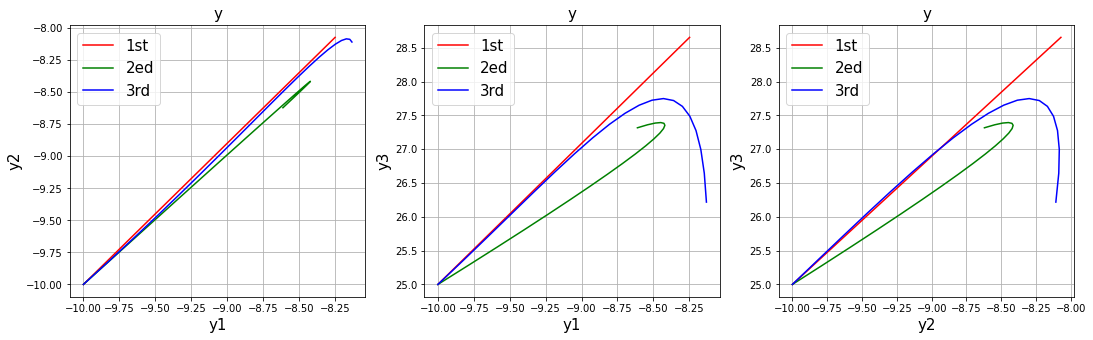

In [41]:
# show_graph
bias = [-10, -10, 25]
test_x = Lorenz_x()
train_x = Lorenz_x()

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)

y11, y12, y13 = [Lorenz_y(test_x, w_1, idx = idx, bias = b) for idx, b in enumerate(bias)]
y21, y22, y23 = [Lorenz_y(test_x, w_2, idx = idx, bias = b) for idx, b in enumerate(bias)]
y31, y32, y33 = [Lorenz_y(test_x, w_3, idx = idx, bias = b) for idx, b in enumerate(bias)]

ax.plot(y11, y12, '-r', label = '1st')
ax.plot(y21, y22, '-g', label = '2ed')
ax.plot(y31, y32, '-b', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

ax2 = fig.add_subplot(132)
ax2.plot(y11, y13, '-r', label = '1st')
ax2.plot(y21, y23, '-g', label = '2ed')
ax2.plot(y31, y33, '-b', label = '3rd')
ax2.set_xlabel('y1', fontsize=15)
ax2.set_ylabel('y3', fontsize=15)
ax2.set_title('y', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(y12, y13, '-r', label = '1st')
ax3.plot(y22, y23, '-g', label = '2ed')
ax3.plot(y32, y33, '-b', label = '3rd')
ax3.set_xlabel('y2', fontsize=15)
ax3.set_ylabel('y3', fontsize=15)
ax3.set_title('y', fontsize=15)
ax3.tick_params(labelsize=10)
ax3.legend(fontsize=15)
ax3.grid()

In [42]:
def model_create(n):
    model_dic = dict()
    for i in range(1, n+1):
        model_dic['model_{}'.format(i)] = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
    return model_dic

def Lorenz_y_EC(x, w, NN, idx, bias):
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y1_NN(x)*x
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y2_NN(x)*x
    '''
    y = bias[idx]
    w = w.v[idx]
    n = w.shape[0]
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y + NN[idx](x)*x

def Lorenz_y_EC_loss(x, w, y_NN, bias, p, alpha, beta):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        y1, y2, y3 = [Lorenz_y_EC(x, w, y_NN, idx, bias) for idx in range(len(bias))]
        
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)
        d_y3 = tape.gradient(y3, x)

        # y1' - (alpha*(y2 - y1))
        # y2' - (y1*(p - y3) - y2)
        # y3' - (y1*y2 - beta*y3)
        loss_1 = d_y1 - (alpha*(y2 - y1))
        loss_2 = d_y2 - (y1*(p - y3) - y2)
        loss_3 = d_y3 - (y1*y2 - beta*y3)

    square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_3)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def Lorenz_EC_train(w, bias, p, alpha, beta):
    # custom train_x
    x = Lorenz_x(n = 20)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # custom model
    model_dic = model_create(n=len(bias))
    y_NN = list(model_dic.values())

    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)

            # custom loss
            total_loss = Lorenz_y_EC_loss(x, w, y_NN, bias, p, alpha, beta)
            grad_y = tape.gradient(total_loss, [model.trainable_variables for model in y_NN])
        
        for grad, model in zip(grad_y, y_NN):
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, Lorenz_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
            
    return y_NN

In [43]:
# show_graph
bias = [-10, -10, 25]
test_x = Lorenz_x()
train_x = Lorenz_x()

print('start w1 EC')
y1_NN = Lorenz_EC_train(w_1, bias = bias, p = 28, alpha = 10, beta = 8/3)
print('start w2 EC')
y2_NN = Lorenz_EC_train(w_2, bias = bias, p = 28, alpha = 10, beta = 8/3)
print('start w3 EC')
y3_NN = Lorenz_EC_train(w_3, bias = bias, p = 28, alpha = 10, beta = 8/3)

start w1 EC
iter : 0, Lorenz_y_total_loss : 352.9281921386719
iter : 5000, Lorenz_y_total_loss : 0.0006465037586167455
iter : 10000, Lorenz_y_total_loss : 8.551733480999246e-05
start w2 EC
iter : 0, Lorenz_y_total_loss : 210.87255859375
iter : 5000, Lorenz_y_total_loss : 0.17490625381469727
iter : 10000, Lorenz_y_total_loss : 0.005787293892353773
start w3 EC
iter : 0, Lorenz_y_total_loss : 189.5621337890625
iter : 5000, Lorenz_y_total_loss : 0.009668037295341492
iter : 10000, Lorenz_y_total_loss : 0.00037998732295818627


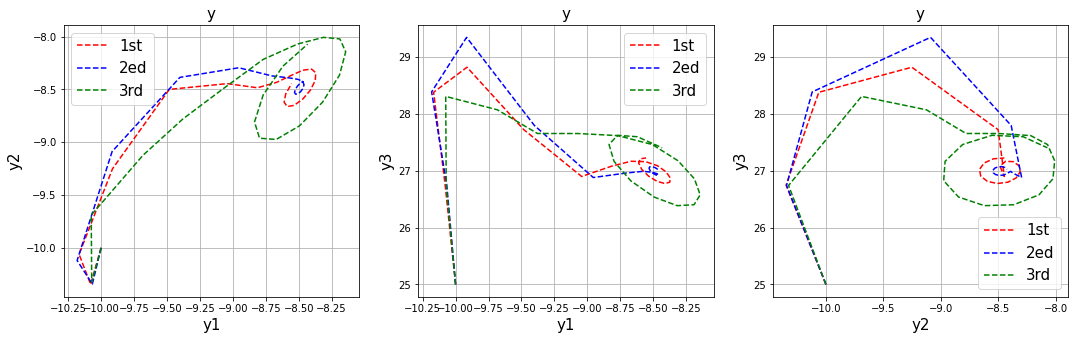

In [44]:
y11_EC, y12_EC, y13_EC = [Lorenz_y_EC(test_x, w_1, y1_NN, idx, bias) for idx in range(len(bias))]
y21_EC, y22_EC, y23_EC = [Lorenz_y_EC(test_x, w_2, y2_NN, idx, bias) for idx in range(len(bias))]
y31_EC, y32_EC, y33_EC = [Lorenz_y_EC(test_x, w_3, y3_NN, idx, bias) for idx in range(len(bias))]

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)

ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

ax2 = fig.add_subplot(132)
ax2.plot(y11_EC, y13_EC, '--r', label = '1st')
ax2.plot(y21_EC, y23_EC, '--b', label = '2ed')
ax2.plot(y31_EC, y33_EC, '--g', label = '3rd')
ax2.set_xlabel('y1', fontsize=15)
ax2.set_ylabel('y3', fontsize=15)
ax2.set_title('y', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(y12_EC, y13_EC, '--r', label = '1st')
ax3.plot(y22_EC, y23_EC, '--b', label = '2ed')
ax3.plot(y32_EC, y33_EC, '--g', label = '3rd')
ax3.set_xlabel('y2', fontsize=15)
ax3.set_ylabel('y3', fontsize=15)
ax3.set_title('y', fontsize=15)
ax3.tick_params(labelsize=10)
ax3.legend(fontsize=15)
ax3.grid()